# HbA1c SIMULATION WITH DYNAMIC DROPOUT RATES

##### DEPENDENCIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

##### SET SIMULATION PARAMETERS

In [3]:
# actual estimates
num_patients = 4675      # 4675
num_years = 20           # 20
num_bootstraps = 1       # 50000

In [4]:
"""
Distribute the the total percentage dropout over specific year ranges:

Years 1–5: 11% total dropout   -> 1-(1-p)^5 = 0.11
Years 6–10: 11% total dropout  -> 1-(1-p)^5 = 0.12
Years 11–15: 11% total dropout -> 1-(1-p)^5 = 0.50
Years 16–20: 11% total dropout -> 1-(1-p)^5 = 0.85

Solving for annual droupout rates p:

        p = 1 - (1-total dropout)^1/5

"""

# Annual dropout probabilities for each period
dropout_rates = { 
    1:  0.0233, 2:  0.0233, 3:  0.0233, 4:  0.0233, 5:  0.0233,  # 1-5 years (total 11%)
    6:  0.0255, 7:  0.0255, 8:  0.0255, 9:  0.0255, 10: 0.0255,  # 6-10 years (total 12%)
    11: 0.1339, 12: 0.1339, 13: 0.1339, 14: 0.1339, 15: 0.1339,  # 11-15 years (total 50%)
    16: 0.2956, 17: 0.2956, 18: 0.2956, 19: 0.2956, 20: 0.2956   # 16-20 years (total 85%)
}

##### FIXED EFFECT (COEFFICIENTS)

In [6]:
# actual estimates
phi_0 = 1.419
phi_1 = 0.724
gamma = 0.141
phi_2 = 0.081
phi_3 = 0.054
beta_ethnicity = [0.046, 0.066]

##### INITIALIZE PATIENT DATA

In [7]:
np.random.seed(42)
patient_ids = np.arange(num_patients)
sex = np.random.choice([0, 1], num_patients)                   # 0=male, 1=female
ethnicity = np.random.choice([0, 1, 2], num_patients)          # 0=reference, 1=Asian-Indian, 2=Afro-Caribbean
year_0 = np.random.uniform(4.95, 8.6, num_patients)            # Initial HbA1c (SBP, LDL) values

##### RANDOM EFFECT

In [8]:
"""
# Define mu_i based on patient characteristics
mu = np.random.normal(0, 0.05, num_patients)                   # Base random effect
mu += 0.05 * sex                                               # Assume females have slightly higher unobserved heterogeneity
mu += 0.03 * (ethnicity == 1) + 0.07 * (ethnicity == 2)        # Ethnicity-dependent effects
"""
sigma = 0.005                                                   # Standard deviation of noise

##### STORE BOOTSTRAPPED DATA

In [9]:
all_bootstrap_data = []

for b in range(num_bootstraps):
    data = []

    # Active patient list starts with everyone
    active_patients = set(patient_ids)

    # Store past values per patient
    patient_history = {pid: year_0[i] for i, pid in enumerate(patient_ids)}
    
    for t in range(1, num_years + 1):
        
        new_active_patients = set()                      # Keep track of patients who stay
        
        for i in list(active_patients):                  # Iterate over active patients only
            
            y_prev = patient_history[patient_ids[i]]     # Retrieve last year's value
            
            diabetes_duration = np.log(t) if t > 1 else 0
            
            # Assign ethnicity effect correctly
            ethnicity_effect = beta_ethnicity[ethnicity[i] - 1] if ethnicity[i] > 0 else 0
            
            # Compute new risk factor value
            y_new = (
                phi_0 + phi_1 * y_prev + gamma * diabetes_duration +
                phi_2 * year_0[i] + phi_3 * sex[i] + ethnicity_effect 
                # + mu[i] 
                + np.random.normal(0, sigma)  # Add noise
            )
            
            # Store results
            data.append({
                'Bootstrap': b + 1, 'Patient_ID': patient_ids[i], 'Year': t, 'Sex': sex[i],
                'Ethnicity': ethnicity[i], 'Diabetes_Duration': t, 'HbA1c': y_new
            })
            
            # Update patient's previous value for next iteration
            patient_history[patient_ids[i]] = y_new
                        
            # Apply dropout condition dynamically based on year
            if np.random.rand() > dropout_rates[t]:  # Keep patient if they don't drop out
                new_active_patients.add(i)
                        
        # Update active patients list for next year
        active_patients = new_active_patients
    
    all_bootstrap_data.extend(data)

##### CONVERT TO DATAFRAME

In [10]:
df = pd.DataFrame(all_bootstrap_data)
# df.to_csv("simulated_data.csv", index=False)

##### DATA VISUALIZATION

In [11]:
# Mapping for Sex and Ethnicity
sex_map = {0: 'Male', 1: 'Female'}
ethnicity_map = {0: 'White & Other', 1: 'Asian-Indian', 2: 'Afro-Caribbean'}

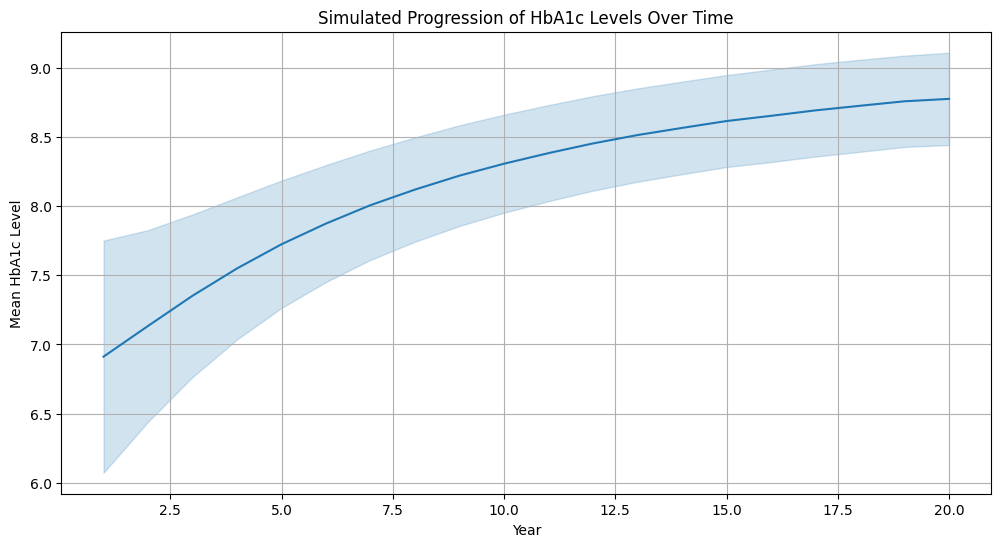

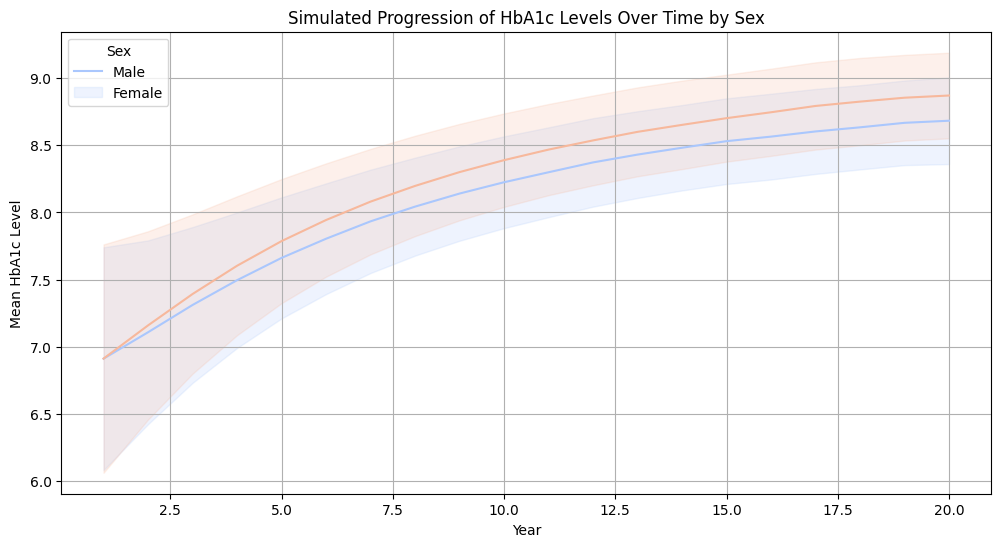

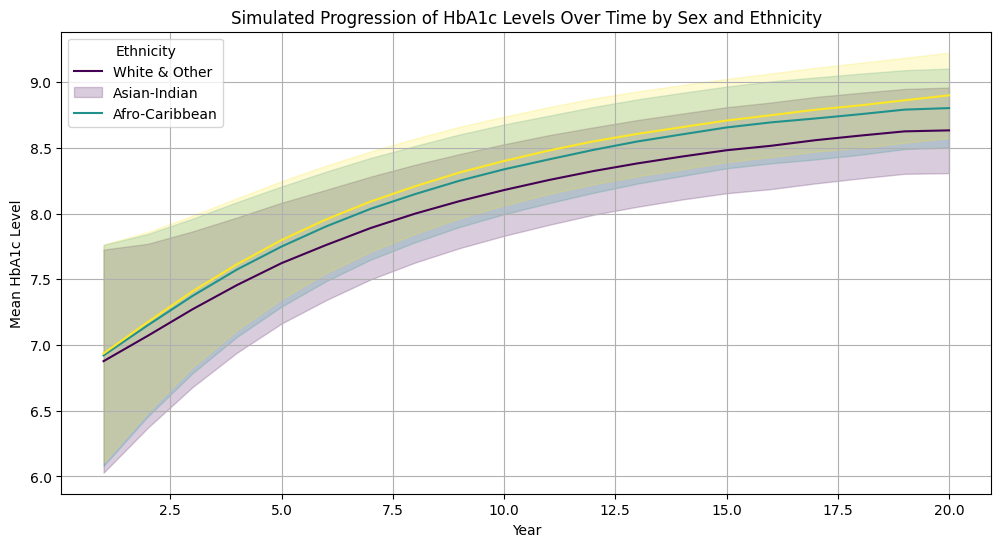

In [10]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='HbA1c', errorbar='sd', estimator='mean')
plt.xlabel('Year')
plt.ylabel('Mean HbA1c Level')
plt.title('Simulated Progression of HbA1c Levels Over Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='HbA1c', hue='Sex', errorbar='sd', estimator='mean', palette='coolwarm')
plt.xlabel('Year')
plt.ylabel('Mean HbA1c Level')
plt.title('Simulated Progression of HbA1c Levels Over Time by Sex')
plt.grid(True)
plt.legend(title='Sex', labels=sex_map.values())
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='HbA1c', hue='Ethnicity', errorbar='sd', estimator='mean', palette='viridis')
plt.xlabel('Year')
plt.ylabel('Mean HbA1c Level')
plt.title('Simulated Progression of HbA1c Levels Over Time by Ethnicity')
plt.grid(True)
plt.legend(title='Ethnicity', labels=ethnicity_map.values())
plt.show()

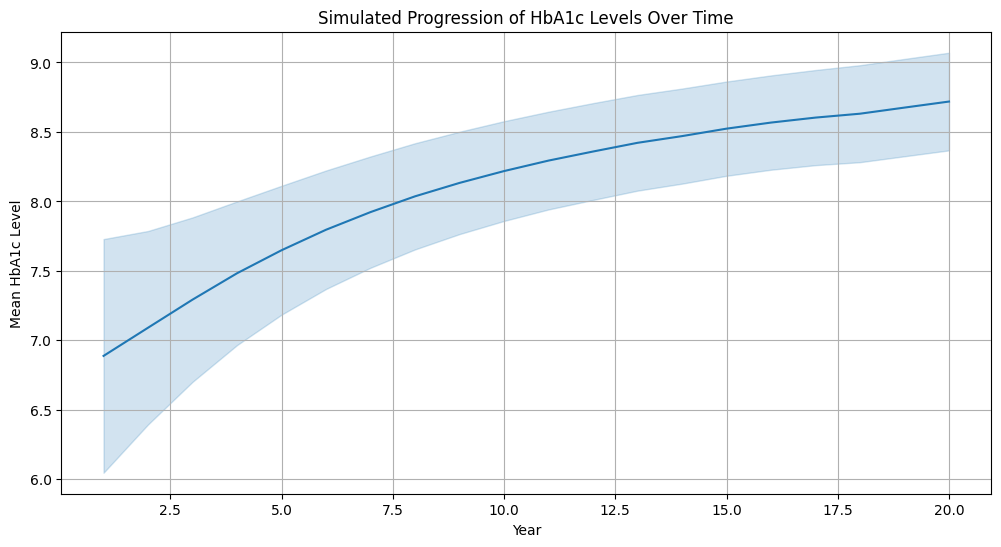

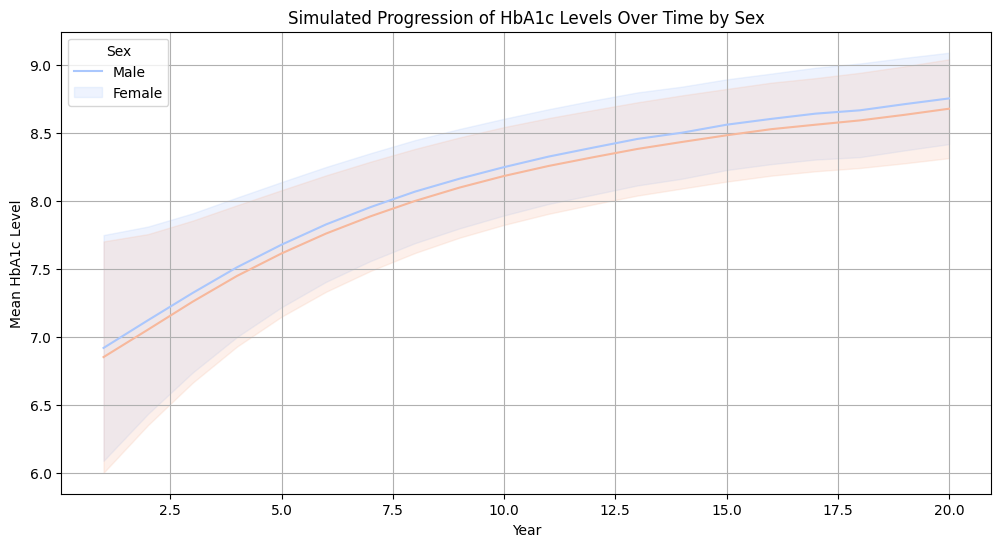

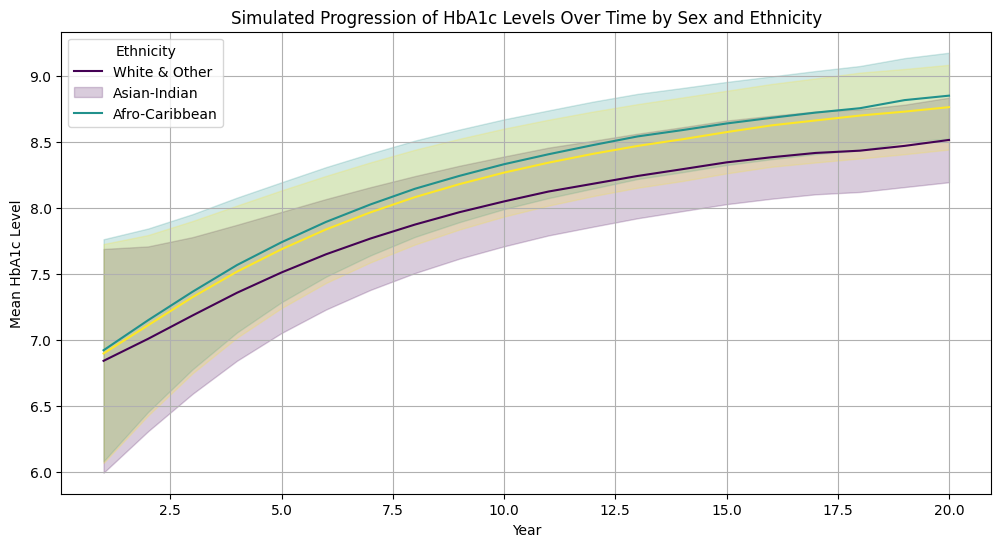

In [11]:
# trial for article_1
phi_3 = -0.014
beta_ethnicity = [0.082, 0.063]

all_bootstrap_data = []

for b in range(num_bootstraps):
    data = []

    # Active patient list starts with everyone
    active_patients = set(patient_ids)

    # Store past values per patient
    patient_history = {pid: year_0[i] for i, pid in enumerate(patient_ids)}
    
    for t in range(1, num_years + 1):
        
        new_active_patients = set()                      # Keep track of patients who stay
        
        for i in list(active_patients):                  # Iterate over active patients only
            
            y_prev = patient_history[patient_ids[i]]     # Retrieve last year's value
            
            diabetes_duration = np.log(t) if t > 1 else 0
            
            # Assign ethnicity effect correctly
            ethnicity_effect = beta_ethnicity[ethnicity[i] - 1] if ethnicity[i] > 0 else 0
            
            # Compute new risk factor value
            y_new = (
                phi_0 + phi_1 * y_prev + gamma * diabetes_duration +
                phi_2 * year_0[i] + phi_3 * sex[i] + ethnicity_effect 
                # + mu[i] 
                + np.random.normal(0, sigma)  # Add noise
            )
            
            # Store results
            data.append({
                'Bootstrap': b + 1, 'Patient_ID': patient_ids[i], 'Year': t, 'Sex': sex[i],
                'Ethnicity': ethnicity[i], 'Diabetes_Duration': t, 'HbA1c': y_new
            })
            
            # Update patient's previous value for next iteration
            patient_history[patient_ids[i]] = y_new
                        
            # Apply dropout condition dynamically based on year
            if np.random.rand() > dropout_rates[t]:  # Keep patient if they don't drop out
                new_active_patients.add(i)
                        
        # Update active patients list for next year
        active_patients = new_active_patients
    
    all_bootstrap_data.extend(data)

df = pd.DataFrame(all_bootstrap_data)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='HbA1c', errorbar='sd', estimator='mean')
plt.xlabel('Year')
plt.ylabel('Mean HbA1c Level')
plt.title('Simulated Progression of HbA1c Levels Over Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='HbA1c', hue='Sex', errorbar='sd', estimator='mean', palette='coolwarm')
plt.xlabel('Year')
plt.ylabel('Mean HbA1c Level')
plt.title('Simulated Progression of HbA1c Levels Over Time by Sex')
plt.grid(True)
plt.legend(title='Sex', labels=sex_map.values())
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='HbA1c', hue='Ethnicity', errorbar='sd', estimator='mean', palette='viridis')
plt.xlabel('Year')
plt.ylabel('Mean HbA1c Level')
plt.title('Simulated Progression of HbA1c Levels Over Time by Sex and Ethnicity')
plt.grid(True)
plt.legend(title='Ethnicity', labels=ethnicity_map.values())
plt.show()

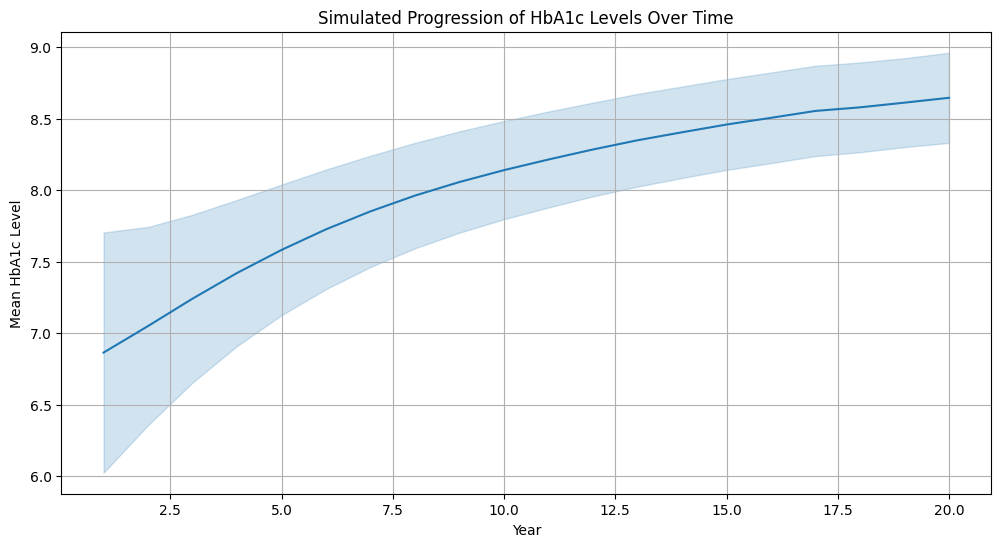

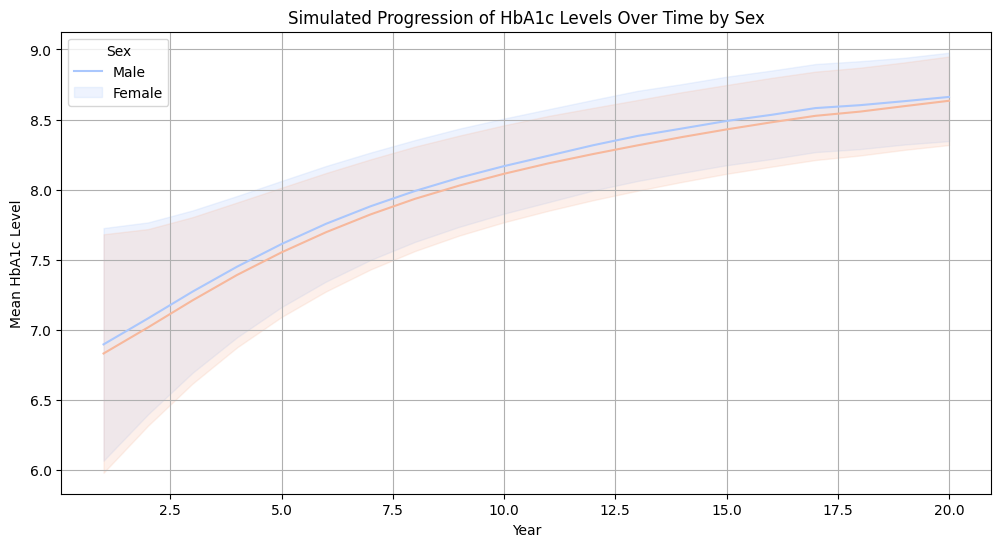

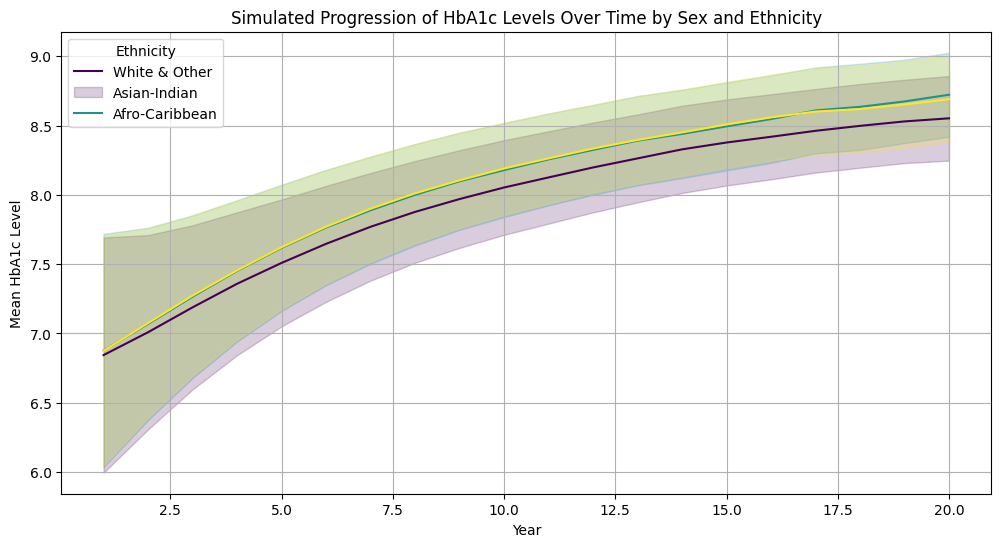

In [12]:
# trial for article_2
phi_3 = -0.012
beta_ethnicity = [0.035, 0.038]

all_bootstrap_data = []

for b in range(num_bootstraps):
    data = []

    # Active patient list starts with everyone
    active_patients = set(patient_ids)

    # Store past values per patient
    patient_history = {pid: year_0[i] for i, pid in enumerate(patient_ids)}
    
    for t in range(1, num_years + 1):
        
        new_active_patients = set()                      # Keep track of patients who stay
        
        for i in list(active_patients):                  # Iterate over active patients only
            
            y_prev = patient_history[patient_ids[i]]     # Retrieve last year's value
            
            diabetes_duration = np.log(t) if t > 1 else 0
            
            # Assign ethnicity effect correctly
            ethnicity_effect = beta_ethnicity[ethnicity[i] - 1] if ethnicity[i] > 0 else 0
            
            # Compute new risk factor value
            y_new = (
                phi_0 + phi_1 * y_prev + gamma * diabetes_duration +
                phi_2 * year_0[i] + phi_3 * sex[i] + ethnicity_effect 
                # + mu[i] 
                + np.random.normal(0, sigma)  # Add noise
            )
            
            # Store results
            data.append({
                'Bootstrap': b + 1, 'Patient_ID': patient_ids[i], 'Year': t, 'Sex': sex[i],
                'Ethnicity': ethnicity[i], 'Diabetes_Duration': t, 'HbA1c': y_new
            })
            
            # Update patient's previous value for next iteration
            patient_history[patient_ids[i]] = y_new
                        
            # Apply dropout condition dynamically based on year
            if np.random.rand() > dropout_rates[t]:  # Keep patient if they don't drop out
                new_active_patients.add(i)
                        
        # Update active patients list for next year
        active_patients = new_active_patients
    
    all_bootstrap_data.extend(data)

df = pd.DataFrame(all_bootstrap_data)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='HbA1c', errorbar='sd', estimator='mean')
plt.xlabel('Year')
plt.ylabel('Mean HbA1c Level')
plt.title('Simulated Progression of HbA1c Levels Over Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='HbA1c', hue='Sex', errorbar='sd', estimator='mean', palette='coolwarm')
plt.xlabel('Year')
plt.ylabel('Mean HbA1c Level')
plt.title('Simulated Progression of HbA1c Levels Over Time by Sex')
plt.grid(True)
plt.legend(title='Sex', labels=sex_map.values())
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='HbA1c', hue='Ethnicity', errorbar='sd', estimator='mean', palette='viridis')
plt.xlabel('Year')
plt.ylabel('Mean HbA1c Level')
plt.title('Simulated Progression of HbA1c Levels Over Time by Sex and Ethnicity')
plt.grid(True)
plt.legend(title='Ethnicity', labels=ethnicity_map.values())
plt.show()

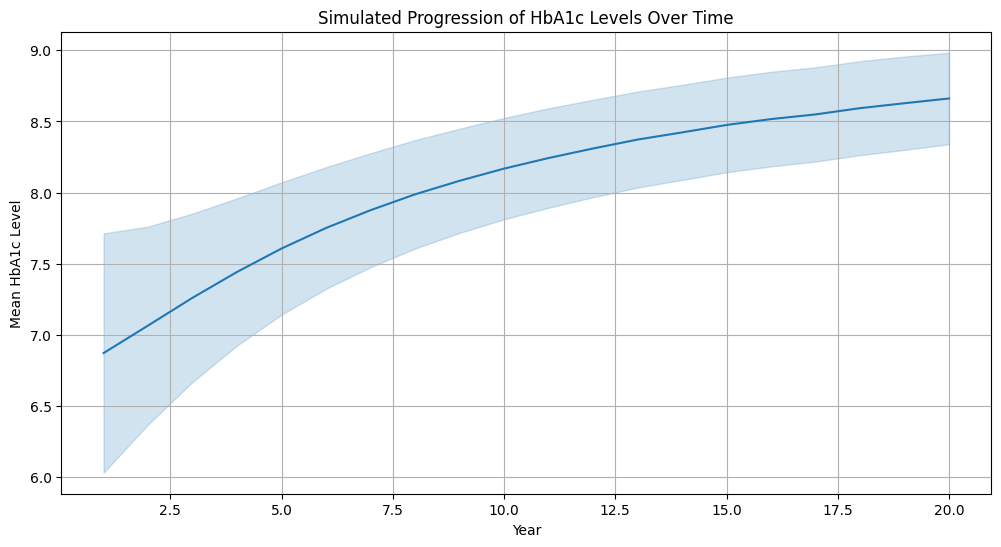

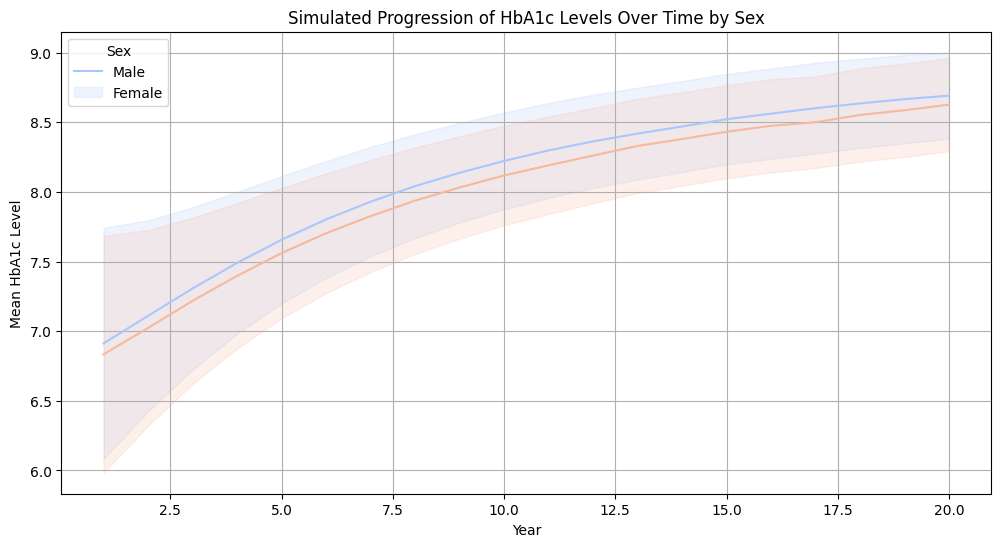

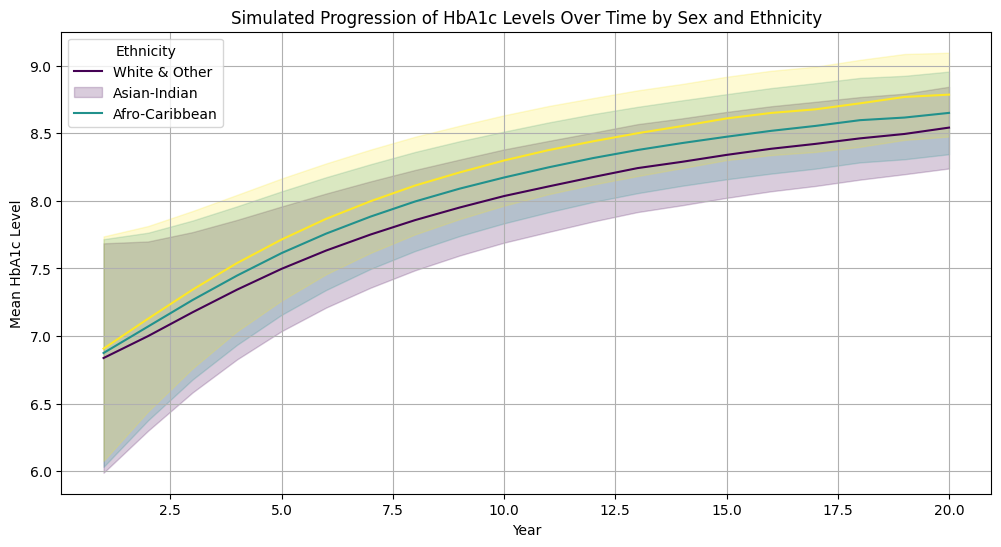

In [13]:
# trial for article_3
phi_3 = -0.025
beta_ethnicity = [0.039, 0.077]

all_bootstrap_data = []

for b in range(num_bootstraps):
    data = []

    # Active patient list starts with everyone
    active_patients = set(patient_ids)

    # Store past values per patient
    patient_history = {pid: year_0[i] for i, pid in enumerate(patient_ids)}
    
    for t in range(1, num_years + 1):
        
        new_active_patients = set()                      # Keep track of patients who stay
        
        for i in list(active_patients):                  # Iterate over active patients only
            
            y_prev = patient_history[patient_ids[i]]     # Retrieve last year's value
            
            diabetes_duration = np.log(t) if t > 1 else 0
            
            # Assign ethnicity effect correctly
            ethnicity_effect = beta_ethnicity[ethnicity[i] - 1] if ethnicity[i] > 0 else 0
            
            # Compute new risk factor value
            y_new = (
                phi_0 + phi_1 * y_prev + gamma * diabetes_duration +
                phi_2 * year_0[i] + phi_3 * sex[i] + ethnicity_effect 
                # + mu[i] 
                + np.random.normal(0, sigma)  # Add noise
            )
            
            # Store results
            data.append({
                'Bootstrap': b + 1, 'Patient_ID': patient_ids[i], 'Year': t, 'Sex': sex[i],
                'Ethnicity': ethnicity[i], 'Diabetes_Duration': t, 'HbA1c': y_new
            })
            
            # Update patient's previous value for next iteration
            patient_history[patient_ids[i]] = y_new
                        
            # Apply dropout condition dynamically based on year
            if np.random.rand() > dropout_rates[t]:  # Keep patient if they don't drop out
                new_active_patients.add(i)
                        
        # Update active patients list for next year
        active_patients = new_active_patients
    
    all_bootstrap_data.extend(data)

df = pd.DataFrame(all_bootstrap_data)

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='HbA1c', errorbar='sd', estimator='mean')
plt.xlabel('Year')
plt.ylabel('Mean HbA1c Level')
plt.title('Simulated Progression of HbA1c Levels Over Time')
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='HbA1c', hue='Sex', errorbar='sd', estimator='mean', palette='coolwarm')
plt.xlabel('Year')
plt.ylabel('Mean HbA1c Level')
plt.title('Simulated Progression of HbA1c Levels Over Time by Sex')
plt.grid(True)
plt.legend(title='Sex', labels=sex_map.values())
plt.show()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Year', y='HbA1c', hue='Ethnicity', errorbar='sd', estimator='mean', palette='viridis')
plt.xlabel('Year')
plt.ylabel('Mean HbA1c Level')
plt.title('Simulated Progression of HbA1c Levels Over Time by Sex and Ethnicity')
plt.grid(True)
plt.legend(title='Ethnicity', labels=ethnicity_map.values())
plt.show()

##### EFFICIENCY OF INTERVENTION (BETA) ANALYSIS

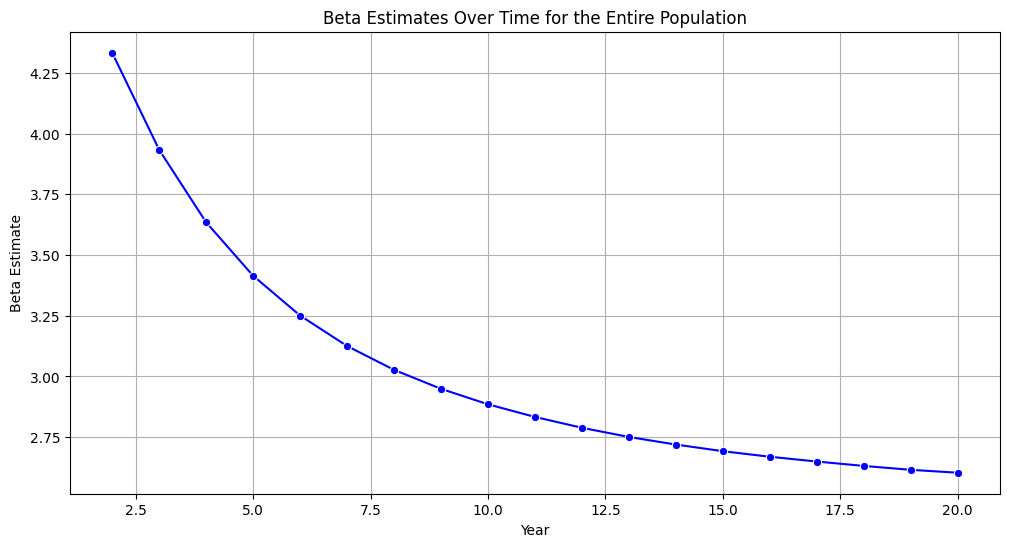

In [44]:
# Compute the mean HbA1c levels per year for the entire population
mean_hba1c_all = df.groupby('Year')['HbA1c'].mean().reset_index()

# Determine the dynamic HbA1c range each year
hba1c_min = df['HbA1c'].min()
hba1c_ref = 6.8
rate_ref = 0.036

# Compute slope for hazard rate assignment
slope = rate_ref / (hba1c_ref - hba1c_min) if hba1c_ref > hba1c_min else 0

def interpolate_initial_rates(hba1c_values, hba1c_min, hba1c_ref, rate_ref, slope):
    initial_rates = np.where(
        hba1c_values < hba1c_ref,
        slope * (hba1c_values - hba1c_min),
        slope * (hba1c_values - hba1c_ref) + rate_ref
    )
    return initial_rates

# Assign initial hazard rates only for Year 1
mean_hba1c_all['Initial_Rate'] = interpolate_initial_rates(
    mean_hba1c_all['HbA1c'], hba1c_min, hba1c_ref, rate_ref, slope
)

def calculate_beta(df_grouped):
    beta_values = [np.nan]  # First year has no beta
    rates = [df_grouped.iloc[0]['Initial_Rate']]  # Initialize rates list using the interpolated rate
    
    for i in range(1, len(df_grouped)):
        hba1c_prev = df_grouped.iloc[i - 1]['HbA1c']
        hba1c_curr = df_grouped.iloc[i]['HbA1c']
        
        rate_prev = rates[-1] if not np.isnan(rates[-1]) else df_grouped.iloc[i - 1]['Initial_Rate']
        rate_curr = rate_prev * (hba1c_curr / hba1c_prev) ** beta_values[-1] if not np.isnan(beta_values[-1]) else rate_prev
        rates.append(rate_curr)
        
        if hba1c_prev > 0 and rate_prev > 0 and hba1c_curr != hba1c_prev:
            beta = np.log(rate_curr / rate_prev) / np.log(hba1c_curr / hba1c_prev)
        else:
            beta = np.nan
        beta_values.append(beta)
    
    return beta_values, rates

# Compute beta estimates for the entire population
mean_hba1c_all['Rate'] = mean_hba1c_all['Initial_Rate']  # Assign initial rates for all years
mean_hba1c_all['Beta'] = np.nan  # Initialize Beta column

for i in range(1, len(mean_hba1c_all)):
    hba1c_prev = mean_hba1c_all.iloc[i - 1]['HbA1c']
    hba1c_curr = mean_hba1c_all.iloc[i]['HbA1c']
    rate_prev = mean_hba1c_all.iloc[i - 1]['Rate']
    
    if hba1c_prev > 0 and rate_prev > 0 and hba1c_curr != hba1c_prev:
        beta = np.log(mean_hba1c_all.iloc[i]['Rate'] / rate_prev) / np.log(hba1c_curr / hba1c_prev)
    else:
        beta = np.nan
    
    mean_hba1c_all.at[i, 'Beta'] = beta
    mean_hba1c_all.at[i, 'Rate'] = rate_prev * (hba1c_curr / hba1c_prev) ** beta if not np.isnan(beta) else rate_prev

# Visualization
plt.figure(figsize=(12, 6))
sns.lineplot(data=mean_hba1c_all, x='Year', y='Beta', marker='o', color='b')
plt.xlabel('Year')
plt.ylabel('Beta Estimate')
plt.title('Beta Estimates Over Time for the Entire Population')
plt.grid(True)
plt.show()

In [45]:
print(mean_hba1c_all)

    Year     HbA1c  Initial_Rate      Rate      Beta
0      1  6.911422      0.038864  0.038864       NaN
1      2  7.133497      0.044573  0.044573  4.333575
2      3  7.352027      0.050191  0.050191  3.933806
3      4  7.549561      0.055269  0.055269  3.634984
4      5  7.724579      0.059768  0.059768  3.414826
5      6  7.874329      0.063617  0.063617  3.250901
6      7  8.007385      0.067038  0.067038  3.125394
7      8  8.120141      0.069936  0.069936  3.027135
8      9  8.220904      0.072527  0.072527  2.948933
9     10  8.307126      0.074743  0.074743  2.885235
10    11  8.383786      0.076714  0.076714  2.833070
11    12  8.453908      0.078516  0.078516  2.788485
12    13  8.514436      0.080072  0.080072  2.750579
13    14  8.566023      0.081398  0.081398  2.719310
14    15  8.615840      0.082679  0.082679  2.691990
15    16  8.653508      0.083647  0.083647  2.669092
16    17  8.693065      0.084664  0.084664  2.649407
17    18  8.726274      0.085518  0.085518  2.

In [46]:
# Compute percentage change from Year 2 to Year 20
initial_beta = mean_hba1c_all.loc[1, 'Beta']
final_beta = mean_hba1c_all.loc[len(mean_hba1c_all) - 1, 'Beta']
beta_change_percentage = ((final_beta - initial_beta) / initial_beta) * 100

# Print the results
print(f"Percentage Change in Beta from Year 2 to Year 20: {beta_change_percentage:.2f}%")

Percentage Change in Beta from Year 2 to Year 20: -39.93%


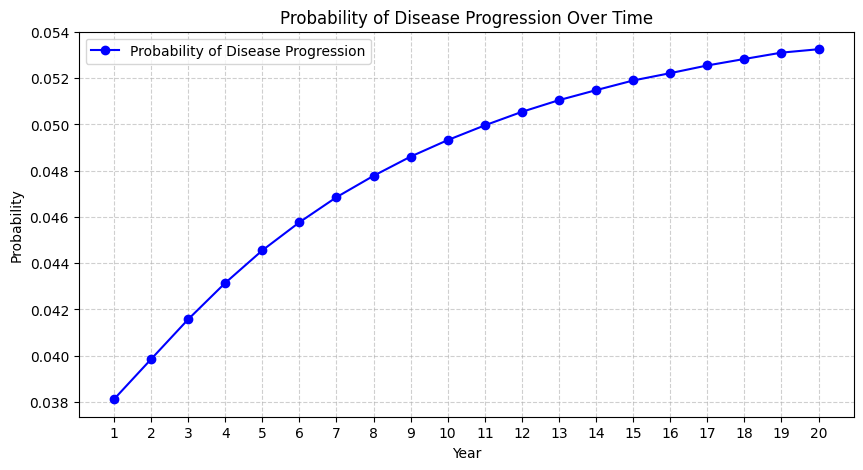

In [40]:
"""
# Compute the mean HbA1c levels per year for the entire population
mean_hba1c_all = df.groupby('Year')['HbA1c'].mean().reset_index()

# Parameters for initial rate calculation
hba1c_min = df['HbA1c'].min()
hba1c_ref = 6.8
rate_ref = 0.036

# Compute slope for hazard rate assignment
slope = rate_ref / (hba1c_ref - hba1c_min) if hba1c_ref > hba1c_min else 0

def interpolate_initial_rates(hba1c_values, hba1c_min, hba1c_ref, rate_ref, slope):
    "Assigns initial rates based on HbA1c levels only for the first year."
    initial_rates = np.where(
        hba1c_values < hba1c_ref,
        slope * (hba1c_values - hba1c_min),
        slope * (hba1c_values - hba1c_ref) + rate_ref
    )
    return initial_rates
"""

# Assign initial hazard rate ONLY for Year 1
mean_hba1c_all['Initial_Rate'] = np.nan
mean_hba1c_all.loc[0, 'Initial_Rate'] = interpolate_initial_rates(
    np.array([mean_hba1c_all.loc[0, 'HbA1c']]), hba1c_min, hba1c_ref, rate_ref, slope
)[0]

# Set the fixed beta value
fixed_beta = 1.4325  # Ensure this remains consistent

# Compute rates dynamically each year using the fixed beta
rates = [mean_hba1c_all.loc[0, 'Initial_Rate']]
betas = [fixed_beta]  # Beta is now assigned properly from Year 1
for i in range(1, len(mean_hba1c_all)):
    hba1c_prev = mean_hba1c_all.loc[i - 1, 'HbA1c']
    hba1c_curr = mean_hba1c_all.loc[i, 'HbA1c']
    rate_prev = rates[-1]

    # Compute rate for the current year using the fixed beta
    rate_curr = rate_prev * (hba1c_curr / hba1c_prev) ** fixed_beta
    rates.append(rate_curr)

    # Beta remains the same throughout
    betas.append(fixed_beta)

mean_hba1c_all['Rate'] = rates
mean_hba1c_all['Beta'] = betas

# Convert rates to probabilities using: Probability = 1 - e^(-Rate * Time)
time = 1  # Yearly interval
mean_hba1c_all['Probability'] = 1 - np.exp(-mean_hba1c_all['Rate'] * time)

# Plot Probability Changes Over the Years
plt.figure(figsize=(10, 5))
plt.plot(mean_hba1c_all['Year'], mean_hba1c_all['Probability'], marker='o', linestyle='-', color='b', label='Probability of Disease Progression')

# Labels and Title
plt.xlabel('Year')
plt.ylabel('Probability')
plt.title('Probability of Disease Progression Over Time')
plt.xticks(mean_hba1c_all['Year'])  # Ensuring all years are labeled
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Show the plot
plt.show()

In [23]:
# Display the updated DataFrame
print(mean_hba1c_all)

    Year     HbA1c  Initial_Rate      Rate    Beta  Probability
0      1  6.911422      0.038864  0.038864  1.4325     0.038119
1      2  7.133497           NaN  0.040665  1.4325     0.039850
2      3  7.352027           NaN  0.042462  1.4325     0.041573
3      4  7.549561           NaN  0.044106  1.4325     0.043147
4      5  7.724579           NaN  0.045578  1.4325     0.044554
5      6  7.874329           NaN  0.046849  1.4325     0.045768
6      7  8.007385           NaN  0.047987  1.4325     0.046854
7      8  8.120141           NaN  0.048958  1.4325     0.047778
8      9  8.220904           NaN  0.049830  1.4325     0.048609
9     10  8.307126           NaN  0.050581  1.4325     0.049323
10    11  8.383786           NaN  0.051251  1.4325     0.049959
11    12  8.453908           NaN  0.051866  1.4325     0.050544
12    13  8.514436           NaN  0.052398  1.4325     0.051049
13    14  8.566023           NaN  0.052854  1.4325     0.051481
14    15  8.615840           NaN  0.0532

In [43]:
# Compute percentage change from Year 1 to Year 20
initial_prob = mean_hba1c_all.loc[0, 'Probability']
final_prob = mean_hba1c_all.loc[len(mean_hba1c_all) - 1, 'Probability']
probability_change_percentage = ((final_prob - initial_prob) / initial_prob) * 100

# Print the results
print(f"Percentage Change in Probability from Year 1 to Year 20: {probability_change_percentage:.2f}%")

Percentage Change in Probability from Year 1 to Year 20: 39.70%
